            Futures1_Position  Futures2_Position
2024-05-10                0.0                0.0
2024-05-11                0.0                0.0
2024-05-12                0.0                0.0
2024-05-13                0.0                0.0
2024-05-14                0.0                0.0
2024-05-10    0.0
2024-05-11    0.0
2024-05-12    0.0
2024-05-13    0.0
2024-05-14    0.0
Freq: D, dtype: float64


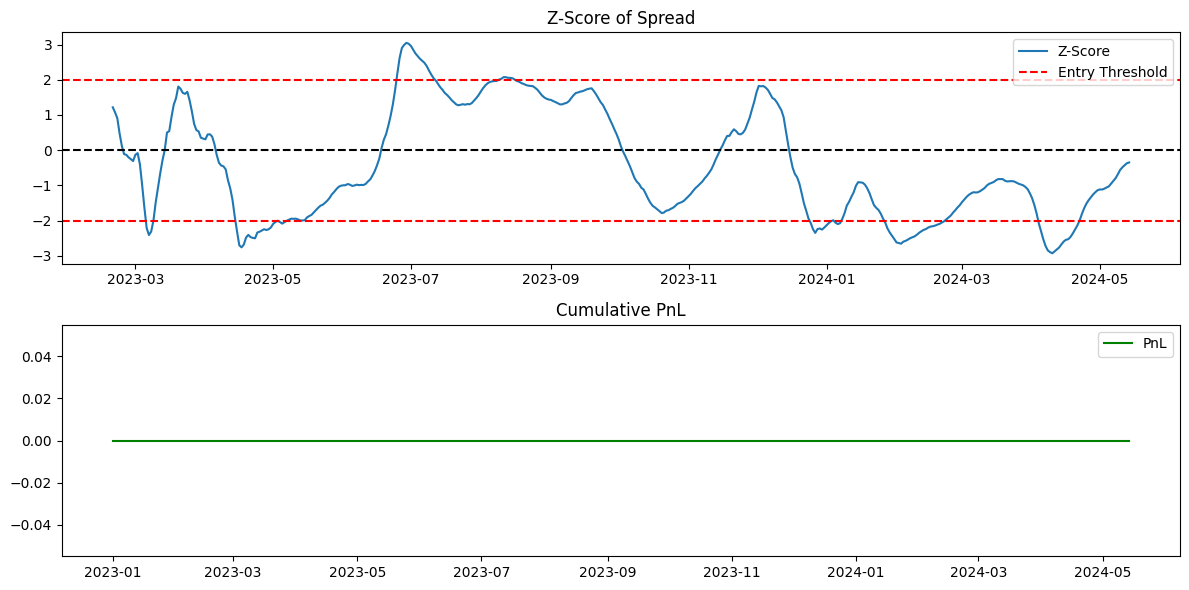

In [4]:
import numpy as np
import pandas as pd
from pykalman import KalmanFilter
import matplotlib.pyplot as plt

# Mock data: Two futures price series (can be any two related futures)
np.random.seed(42)
n = 500
time_index = pd.date_range('2023-01-01', periods=n)
futures1 = np.cumsum(np.random.normal(0, 1, n)) + 100  # Mock prices for futures contract 1
futures2 = np.cumsum(np.random.normal(0, 1, n)) + 102  # Mock prices for futures contract 2
data = pd.DataFrame({'Futures1': futures1, 'Futures2': futures2}, index=time_index)

# Apply Kalman Filter to estimate the spread between two futures contracts
def kalman_filter_estimation(price1, price2):
    delta = 1e-3  # Small delta for process noise
    trans_cov = delta / (1 - delta) * np.eye(2)  # Process covariance matrix

    kf = KalmanFilter(
        transition_matrices=np.eye(2),
        observation_matrices=np.expand_dims([1, -1], axis=0),
        initial_state_mean=np.zeros(2),
        initial_state_covariance=np.ones((2, 2)),
        observation_covariance=1.0,
        transition_covariance=trans_cov
    )

    state_means, _ = kf.filter(np.expand_dims(price1 - price2, axis=1))
    return state_means[:, 0]  # Estimated spread

# Calculate the spread and z-score
spread = kalman_filter_estimation(data['Futures1'], data['Futures2'])
spread_series = pd.Series(spread, index=data.index)  # Convert spread to Pandas Series
spread_mean = spread_series.rolling(window=50).mean()
spread_std = spread_series.rolling(window=50).std()
z_score = (spread_series - spread_mean) / spread_std

# Trading strategy: Mean-reversion based on z-score
entry_threshold = 2
exit_threshold = 0

positions = pd.DataFrame(index=data.index, columns=['Futures1_Position', 'Futures2_Position'])
positions['Futures1_Position'] = 0
positions['Futures2_Position'] = 0

# Generate positions based on z-score
positions.loc[z_score > entry_threshold, ['Futures1_Position', 'Futures2_Position']] = [-1, 1]  # Short futures1, Long futures2
positions.loc[z_score < -entry_threshold, ['Futures1_Position', 'Futures2_Position']] = [1, -1]  # Long futures1, Short futures2
positions.loc[(z_score < exit_threshold) & (z_score > -exit_threshold), :] = [0, 0]  # Close positions

# Backtesting: Compute PnL
# Shift positions by 1 to ensure that today's returns are based on yesterday's positions
returns = data.pct_change()
shifted_positions = positions.shift(1)
pnl = shifted_positions.mul(returns).sum(axis=1).cumsum()

# Print to check if trades are being executed
print(shifted_positions.tail())
print(pnl.tail())

# Plotting
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(data.index, z_score, label='Z-Score')
plt.axhline(entry_threshold, color='r', linestyle='--', label='Entry Threshold')
plt.axhline(-entry_threshold, color='r', linestyle='--')
plt.axhline(0, color='k', linestyle='--')
plt.title('Z-Score of Spread')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(data.index, pnl, label='PnL', color='g')
plt.title('Cumulative PnL')
plt.legend()
plt.tight_layout()
plt.show()
